<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/RNA_Workshop/Analyze_BMX_scRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install scanpy --quiet
import h5py
import numpy as np
import scipy as sci
from matplotlib import pyplot as plt
import scanpy as sc
import tarfile
import os
import anndata as ad
import pandas as pd
import pybiomart
import shutil
from tqdm import tqdm
import urllib.request
from IPython.display import clear_output
from matplotlib.pyplot import rc_context
from scipy import stats as st
import logging
logger = logging.basicConfig(level=logging.INFO,format='%(asctime)s  %(message)s', datefmt='%Y/%m/%d %I:%M:%S %p',force=True)



In [33]:
def z_score(x,axis=-1):
    x=np.array(x)
    return (x-np.mean(x,axis=axis))/np.std(x,axis=axis)

def publishable_plots(FS=6):
    plt.rcParams.update({'font.size': FS,'axes.linewidth':.5,'figure.dpi':300,
                         'xtick.major.width': 0.5,'ytick.major.width': 0.5,
                         'figure.titlesize':FS,'axes.titlesize': FS,'xtick.labelsize': FS,
                         'ytick.labelsize':FS,'axes.labelsize': FS,'legend.fontsize': FS,
                         'figure.labelsize':FS})

    import urllib.request
    arial_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Fonts/arial.ttf'
    filename = './arial.ttf'
    urllib.request.urlretrieve(arial_link, filename)
    plt.rcParams.update({'font.family': 'arial'})

    try:
        sc.settings.verbosity = 'error'             # verbosity: errors (0), warnings (1), info (2), hints (3)
        sc.settings.set_figure_params(dpi=300, facecolor='white',fontsize=FS)
    except: None
    return None


def pull_gene_annots(csv_loc='./mmusculus_coding_noncoding.csv',
                     my_git='https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv',
                     biomart_name='mmusculus',
                     biomart_keys=["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name","peptide"]):

    logging.info('pulling gene annotations...')
    if os.path.exists('./mmusculus_coding_noncoding.csv'):
        logging.info( 'Use local copy of musmus')
        annot_dd = pd.read_csv('./mmusculus_coding_noncoding.csv').set_index("external_gene_name")
    else:
        try:
            logging.info( 'attempting to pull mus mus from git...')
            musmus_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Genetics/mmusculus_coding_noncoding.csv'
            filename = './mmusculus_coding_noncoding.csv'
            urllib.request.urlretrieve(musmus_link, filename)
            annot_dd = pd.read_csv(filename).set_index("external_gene_name")
        except:
            logging.info('attempting to pull mus mus from biomart...')
            annot = sc.queries.biomart_annotations("mmusculus",["ensembl_gene_id", "chromosome_name","transcript_biotype","external_gene_name"],).set_index('ensembl_gene_id')
            uniq_inds = list(set(list(annot.index)))
            for r in tqdm(uniq_inds):
                match_bool = annot.index.str.contains(r)
                if np.sum(match_bool)>1:
                    new_val ='__'.join(list(annot.loc[r,'transcript_biotype']))
                    annot.at[r,'transcript_biotype']=new_val
            annot['is_coding']= annot.transcript_biotype.str.contains('coding')
            annot_dd = annot.drop_duplicates().set_index("external_gene_name")
            annot_dd.to_csv('./mmusculus_coding_noncoding.csv')

    coding_list = annot_dd.index[ annot_dd['is_coding'] ].to_list()
    return coding_list, annot_dd


def copy_original_data():
    ##### Find and Copy MTX DAta
    subfolder='/outs/raw_gene_bc_matrices/mm10-1.2.0_premrna/'
    parent_folder='//hive.gladstone.internal/Huang-Lab/kzalocus/bumex_snSeq/'
    needed_files = ['/barcodes.tsv', '/genes.tsv', '/matrix.mtx']
    dest_folder = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/snBMX/'

    folder_list = [f.name for f in os.scandir(parent_folder) if f.is_dir()]
    folder_list = [f for f in folder_list if "_" in f]
    _=[logging.info(f) for f in folder_list if "_" in f]


    f = folder_list[0]
    f_list = [''.join([parent_folder,f,subfolder,n]) for n in needed_files] #
    logging.info(f_list)

    for f in folder_list:
        for n in needed_files:
            src = ''.join([parent_folder,f,subfolder,n])
            try:
                logging.info(''.join([dest_folder,f,'/']))
                os.makedirs(''.join([dest_folder,f,'/']))
            except: None
            dst = ''.join([dest_folder,f,n])
            logging.info(src)
            logging.info(dst)
            shutil.copyfile(src, dst)
    return None


publishable_plots(6)
pd.set_option('display.max_rows',100)

In [34]:
key_loc = 'https://raw.githubusercontent.com/dtabuena/Workshop/61a957d8c34d5c46c6ab7cc52e1f0330607aaf86/RNA_Workshop/UNOFFICIAL_apoE_BMX_key.csv'
data_key = pd.read_csv(key_loc).set_index('Animal')
display(data_key)

,Treatment
Animal,
E3Ki3607,BMX
E3Ki3608,BMX
E3Ki3611,BMX
E3Ki3612,VEH
E3Ki3613,VEH
E3Ki3614,VEH
E4Ki2710,VEH
E4Ki2711,VEH
E4Ki2712,VEH


In [35]:
working_dir = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/snBMX/'
os.chdir(working_dir)
folder_list = [f.path for f in os.scandir(working_dir) if f.is_dir() and '_' in f.name]
if len(folder_list)==0:
    copy_original_data()
    folder_list = [f.path for f in os.scandir(working_dir) if f.is_dir() and '_' in f.name]
adata_dict = {}
for f in tqdm(folder_list):
    a = sc.read_10x_mtx(f)
    sample_ID = f.split('/')[-1]
    adata_dict[sample_ID]=a
    a=[]
adata = ad.concat(adata_dict,axis = 0,label="sample",index_unique="_")




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:08<00:00,  5.69s/it]


In [36]:
adata.obs['treatment'] = [ data_key.loc[bc.split('_')[-1],'Treatment']  for bc in adata.obs.index]
adata.obs['apoe_iso'] = [s.split('_')[-1][:4] for s in adata.obs['sample']]

In [37]:
def preprocess_andata10x(adata_og,pct_mito=0.25,min_genes=200,max_genes=2400,min_counts=100,max_counts=4500):


    coding_list, _ = pull_gene_annots()


    # adata_og.var['mt'] = adata_og.var_names.str.startswith('mt-')
    # adata_og.var['coding'] = [gene in coding_list for gene in adata_og.var_names]
    # sc.pp.calculate_qc_metrics(adata_og, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adata_filt = adata_og.copy()

    adata_filt.var['mt'] = adata_filt.var_names.str.startswith('mt-')
    adata_filt.var['coding'] = [gene in coding_list for gene in adata_filt.var_names]
    sc.pp.calculate_qc_metrics(adata_filt, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    display(adata_filt.var.head())
    # adata_filt.var['not_mt'] =  np.logical_not( adata_filt.var['mt'])

    # logging.info('Filtering...')
    # adata_filt = adata_filt[adata_filt.obs.pct_counts_mt < pct_mito, :]
    # logging.info(str(np.sum(adata_og.obs.pct_counts_mt <pct_mito)) + f' cells with >{pct_mito}% mt-RNA removed')
    # adata_filt = adata_filt[:, adata_filt.var.coding]
    # logging.info(str(np.sum(np.logical_not(adata_og.var.coding))) + ' non coding genes removed')
    # sc.pp.filter_cells(adata_filt, min_genes=min_genes)
    # sc.pp.filter_cells(adata_filt, max_genes=max_genes)
    # sc.pp.filter_cells(adata_filt, min_counts=min_counts)
    # sc.pp.filter_cells(adata_filt, max_counts=max_counts)
    # fig,ax=plt.subplots(1,figsize=(1.5,1.5))
    # sc.pl.scatter(adata_filt, x='total_counts', y='n_genes_by_counts',ax=ax)
    # logging.info(str(len(adata_filt.obs))+' cells remaining')
    return adata_filt,adata_og

adata_filt = preprocess_andata10x(adata)[0]

2023/10/03 01:39:54 PM  pulling gene annotations...
2023/10/03 01:39:54 PM  Use local copy of musmus


,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,True,49379,8.423643e-03,99.441879,74527.0
Gm1992,False,False,3590,4.295066e-04,99.959423,3800.0
Gm37381,False,False,3,3.390842e-07,99.999966,3.0
Rp1,False,True,51,5.764432e-06,99.999424,51.0
Rp1-1,False,False,0,0.000000e+00,100.000000,0.0


C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


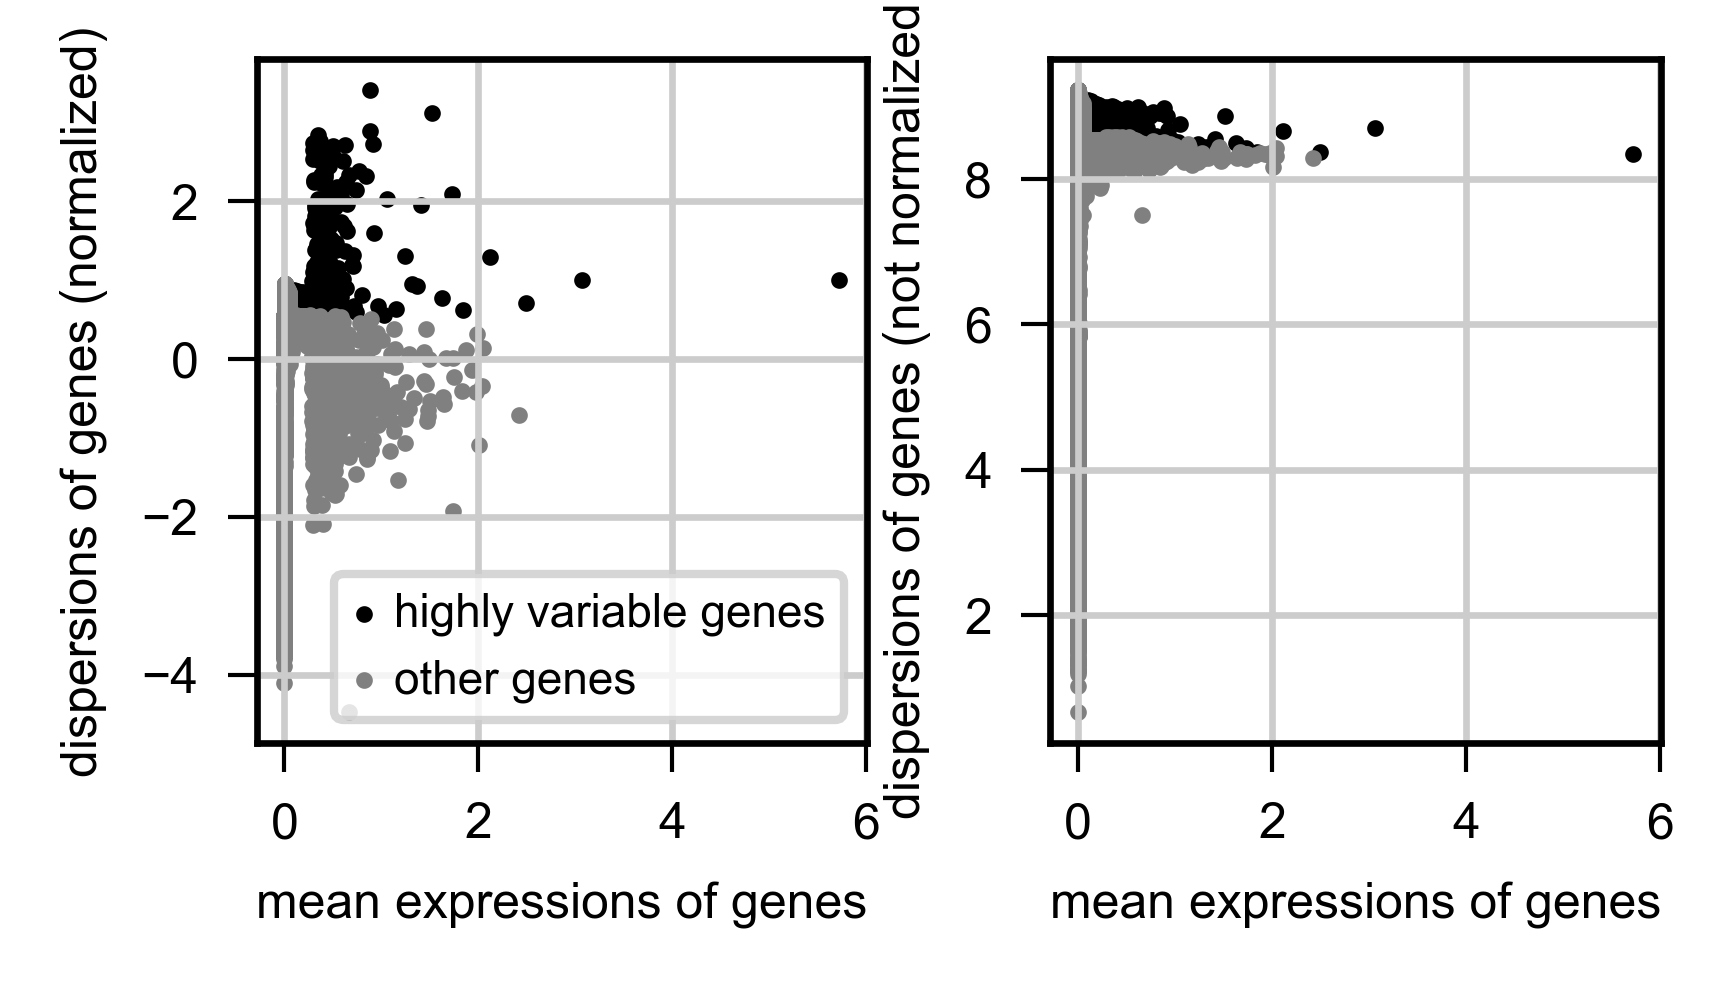

2023/10/03 01:40:06 PM  3339 highly variable genes


<Figure size 1200x1200 with 0 Axes>

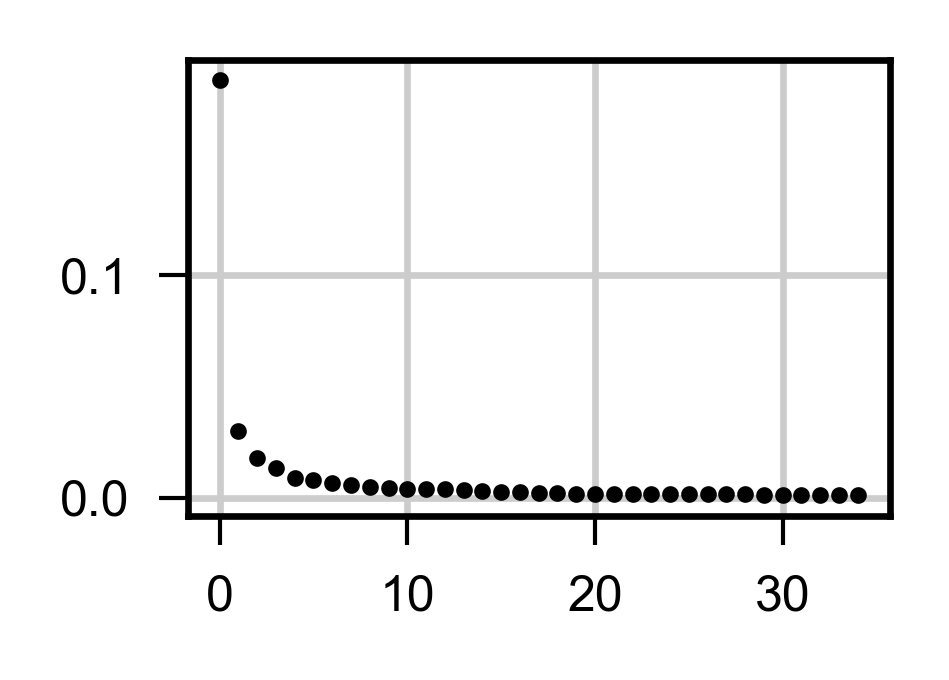

In [38]:

def high_var_genes_dim_reduc(adata,min_mean = 0.25,max_mean = 4,min_disp=0.55,pca_list=[],to_plot_pc=False):
    ''' The gene expression matrices were then log-normalized with a scale factor of 10,000,
    using the Seurat NormalizeData function57,58. Highly dispersed genes were selected using
    the Seurat FindVariableGenes function57,58,filtering for an average expression range of
    0.25–4 and a minimum dispersion of 0.55, resulting in a list of 2,197 genes.'''
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    with rc_context({'figure.figsize': (1.5, 1.5)}):
        sc.pl.highly_variable_genes(adata)
    plt.tight_layout()
    logging.info(str(np.sum(adata.var['highly_variable'])) + ' highly variable genes')


    #### PCA
    sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
    fig,ax=plt.subplots(figsize=(1.5,1))
    ax.plot(adata.uns['pca']['variance_ratio'][:35],'ok',markersize=1)
    if to_plot_pc:
        quiet_PCA_plots(adata,pca_list,pc_pairs=[(0,1),(2,3),(4,5),(6,7)])

    return adata

def quiet_PCA_plots(adata,key_list,figsize=(1.5, 1.5),pc_pairs=[(0,1)]):
    fig,ax=plt.subplots(1*len(pc_pairs),len(key_list),figsize=(figsize[0]*len(key_list),figsize[1]*len(pc_pairs)))
    for ip,pair in enumerate(pc_pairs):
        if len(key_list) == 1: ax=[ax]
        for key_ind,key in enumerate(key_list):
            key_types = sorted(list(set( adata.obs[key] )))
            for k in key_types:
                is_k = adata.obs[key]==k
                ax[ip,key_ind].scatter(adata.obsm['X_pca'][is_k,pair[0]],adata.obsm['X_pca'][is_k,pair[1]],s=2,marker='.',linewidth=0,edgecolors=None,label=k)
                ax[ip,key_ind].set_xlabel(f'PC{pair[0]}')
                ax[ip,key_ind].set_ylabel(f'PC{pair[1]}')
            if len(key_types)<8: ax[ip,key_ind].legend(key_types,loc='best',markerscale=3)
            ax[ip,key_ind].set_title(key)
            plt.tight_layout()
    return None


adata_QC = high_var_genes_dim_reduc(adata_filt,min_mean = 0.05,max_mean = 6,min_disp=0.55,pca_list=[])

In [39]:
############## GABAERGIC Filter #####################
adata_GABA = adata_QC.copy()
adata_GABA.obs['Gad1_pos'] = z_score(sc.get.obs_df(adata_GABA,'Gad1'))>0.5
adata_GABA.obs['Gad2_pos'] = z_score(sc.get.obs_df(adata_GABA,'Gad2'))>0.5
adata_GABA.obs['Syn1_pos'] = z_score(sc.get.obs_df(adata_GABA,'Syn1'))>-100
is_gaba = np.logical_and( np.logical_or(adata_GABA.obs['Gad1_pos'] , adata_GABA.obs['Gad2_pos'] ), adata_GABA.obs['Syn1_pos'])
adata_GABA.obs['Gabaergic'] = is_gaba
adata_GABA = adata_GABA[ adata_GABA.obs['Gabaergic'] ,:]
percent_gaba = np.sum(is_gaba)/len(is_gaba)*100
logging.info(str(len(adata_GABA.obs)) + f' Gabaergic cells {percent_gaba}%')

2023/10/03 01:40:45 PM  5778 Gabaergic cells 0.0653076171875%


C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


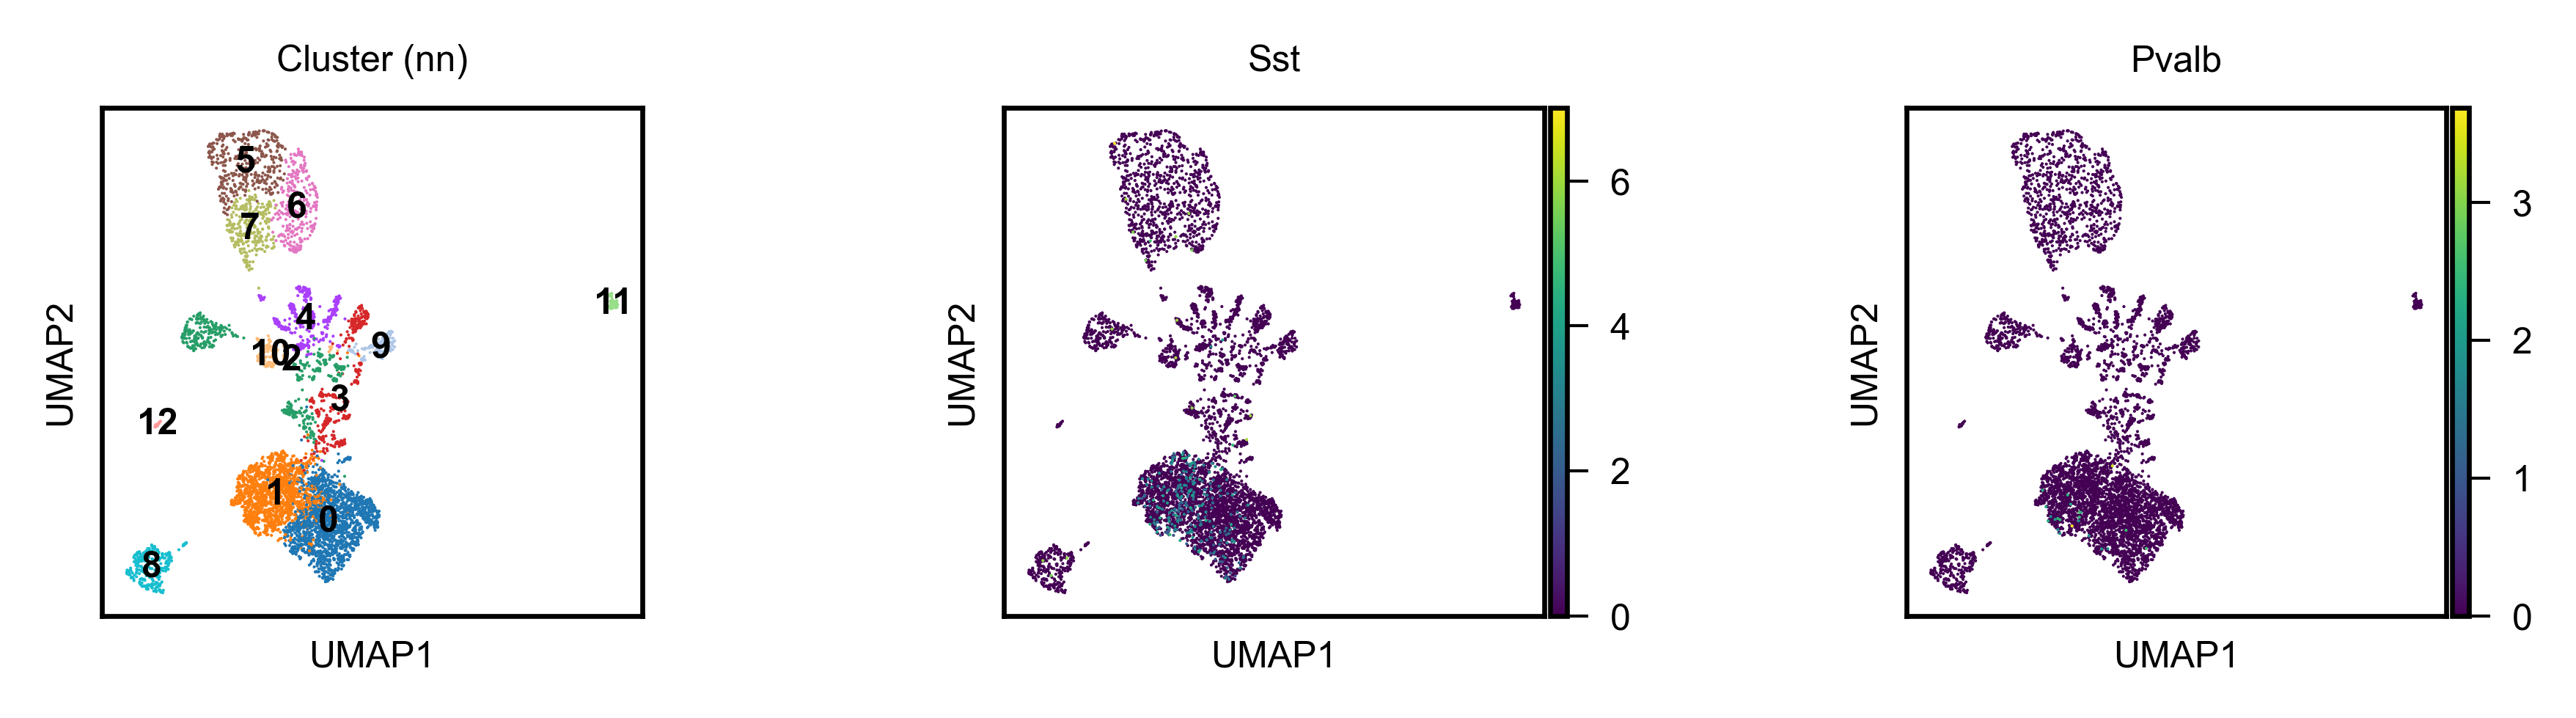

C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 450x450 with 0 Axes>

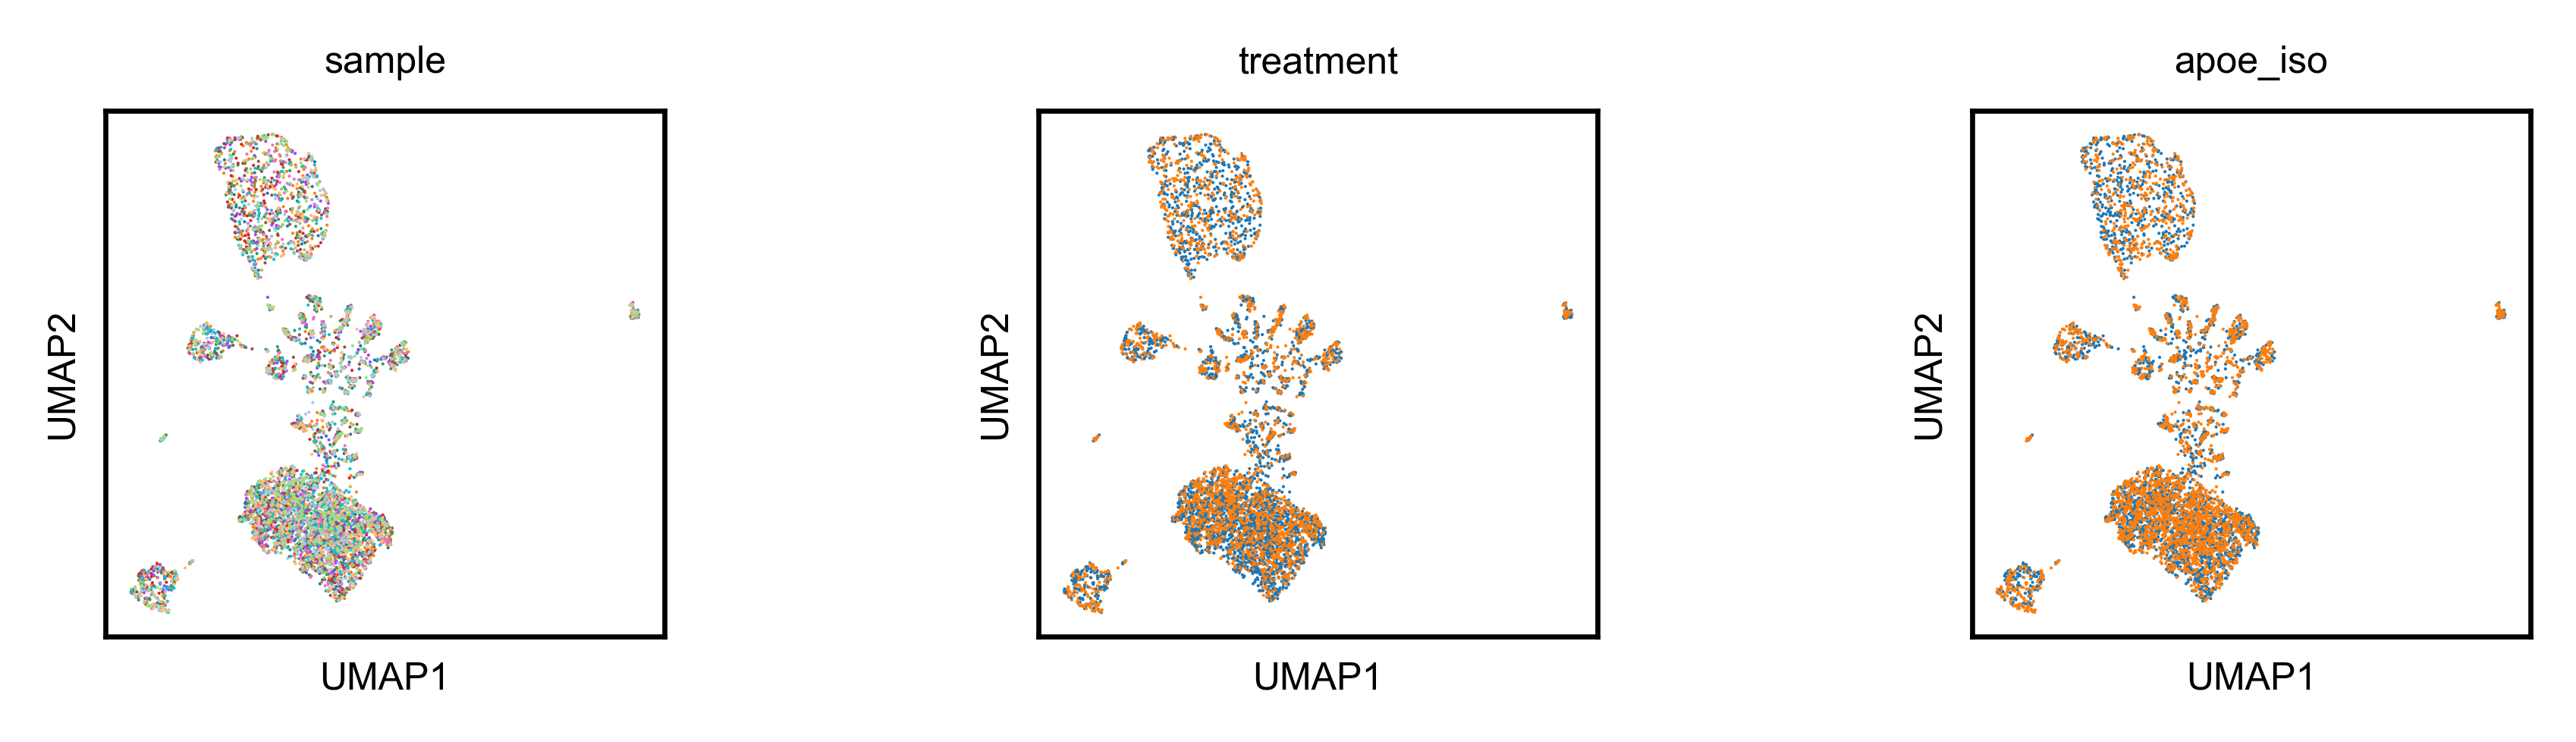

,mt,coding,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
Xkr4,False,True,49379,8.423643e-03,99.441879,74527.0,False,9.148550e-01,8.341748,-0.443836
Gm1992,False,False,3590,4.295066e-04,99.959423,3800.0,False,5.785913e-02,8.339628,0.438604
Gm37381,False,False,3,3.390842e-07,99.999966,3.0,False,5.691738e-04,8.509826,0.539384
Rp1,False,True,51,5.764432e-06,99.999424,51.0,False,7.988226e-04,5.828195,-1.048497
Rp1-1,False,False,0,0.000000e+00,100.000000,0.0,False,1.000000e-12,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
AC168977.1,False,False,10,1.130281e-06,99.999887,10.0,False,2.318690e-04,5.999972,-0.946783
PISD,False,False,28573,3.817184e-03,99.677045,33772.0,True,9.155341e-01,8.856040,2.721439
DHRSX,False,False,603,6.838198e-05,99.993184,605.0,False,2.524632e-02,8.681524,0.641052
Vmn2r122,False,False,0,0.000000e+00,100.000000,0.0,False,1.000000e-12,NaN,0.000000


<Figure size 450x450 with 0 Axes>

In [47]:
def umap_and_cluster(adata, n_neighbors=15, n_pcs=25,resolution=.6,plot_keys=['Cluster (nn)'],size = 1,to_plot=True):
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=42)
    sc.tl.louvain(adata,resolution=resolution,random_state=42)
    sc.tl.paga(adata)
    sc.tl.umap(adata,random_state=42)
    adata.obs['Cluster (nn)']= adata.obs['louvain']
    if to_plot:
        with rc_context({'figure.figsize': (2.5, 2.5)}):
            sc.pl.umap(adata,add_outline=False, legend_loc='on data', color=plot_keys,size=size)
    return adata

def explore_umap(adata_GABA,key_list=[],size=1,legend_loc=None):
    with rc_context({'figure.figsize': (1.5,1.5)}):
        sc.pl.umap(adata_GABA, legend_loc=legend_loc, color=key_list,vmin=0,size=size) # add_outline=True,
        plt.tight_layout()

def get_gene_cluster(adata,gene):
    gene_bool = z_score(sc.get.obs_df(adata,gene))>2
    gene_cluster_list = np.array(adata.obs['louvain'][gene_bool])
    gene_clust = st.mode(gene_cluster_list)
    return gene_clust[0][0]


adata_GABA = umap_and_cluster(adata_GABA, n_neighbors=15, n_pcs=15,resolution=.6,to_plot=False)
explore_umap(adata_GABA,['Cluster (nn)','Sst','Pvalb'],legend_loc='on data')
explore_umap(adata_GABA,['sample','treatment','apoe_iso'])
# explore_umap(adata_GABA,['Sst'])
adata_GABA.var

In [49]:
def get_gene_cluster(adata,gene):
    gene_bool = z_score(sc.get.obs_df(adata,gene))>2
    logging.info(str(np.sum(gene_bool)) + ' ' + gene +' positive')
    gene_cluster_list = np.array(adata.obs['louvain'][gene_bool])
    gene_clust = st.mode(gene_cluster_list)
    return gene_clust[0][0]

sst_clust = get_gene_cluster(adata_GABA,'Sst')
pv_clust = get_gene_cluster(adata_GABA,'Pvalb')

print('sst_clust',sst_clust)
print('pv_clust',pv_clust)

2023/10/04 09:38:24 AM  273 Sst positive
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_20404\3995360647.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  gene_clust = st.mode(gene_cluster_list)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_20404\3995360647.py:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  gene_clust = st.mode(gene_cluster_list)
2023/10/04 09:38:24 AM  22 Pvalb positive


sst_clust 1
pv_clust 1


C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_20404\3995360647.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  gene_clust = st.mode(gene_cluster_list)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_20404\3995360647.py:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  gene_clust = st.mode(gene_cluster_list)
